In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference

from model_v0 import DumbDiscretizer, pgmpy_friendly_transformer

c:\Users\elkan\anaconda3\envs\time_series\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters of the experience 

In [53]:
nb_points = 1000  # nb of points in the dataset
sliding_window = 5  # sliding winodw for pgmpy dataset

Generate data 

In [54]:
# function to generate data 

def generate_data(nb):
    """
    Given an integer generate data as describe above.

    :params nb: int 
        Number of datapoints to generate

    :return dictionary 
        Keys are "States" and "Observations". 
    """
    
    # initialize state vector 
    X1 = np.zeros(nb, dtype=np.float64)
    X2 = np.zeros(nb, dtype=np.float64)
    Y = np.zeros(nb, dtype=np.float64)

    # generate random variables 
    epsilon_1 = np.random.normal(0, scale=5, size=nb-1)
    epsilon_2 = np.random.normal(10, scale=1, size=nb-1)
    epsilon_3 = np.random.normal(0, scale=1, size=nb-1)

    for i in range(0, nb):
        """if i == 0: 
            X1[i] = np.random.uniform(-150, 150)
            X2[i] = np.random.uniform(-150, 150)
            Y[i] = np.random.uniform(-150, 150)
            continue"""

        X1[i] = X1[i-1] + epsilon_1[i-1]
        # X2[i] = .5 * (X1[i] + X1[i-1]) - X2[i-1] + epsilon_2[i-1]
        X2[i] = .33 * (X1[i] + X1[i-1] + X2[i-1]) + epsilon_2[i-1]
        Y[i] = np.abs(X2[i]) + epsilon_3[i-1]

    return X1, X2, Y

In [55]:
# generate random data
X1, X2, Y = generate_data(nb_points)

# convert to dataframe
my_data = pd.DataFrame()
my_data["X1"] = X1
my_data["X2"] = X2
my_data["Y"] = Y

# observe subsample
my_data.head()

,X1,X2,Y
0,6.422995,12.905442,12.009182
1,4.630237,17.092561,17.111541
2,5.660966,20.943987,22.126572
3,4.105464,19.899899,21.394138
4,8.418740,19.877454,20.801096


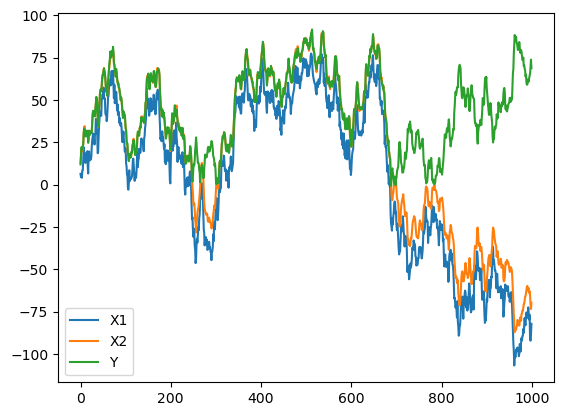

In [56]:
plt.plot(np.arange(nb_points), X1, label="X1")
plt.plot(np.arange(nb_points), X2, label="X2")
plt.plot(np.arange(nb_points), Y, label="Y")

plt.legend()

### Discretization 

In [57]:
nb_classes = {
    "X1": 30, 
    "X2": 30, 
    "Y": 30
}

discretizer = DumbDiscretizer(my_data, nb_classes=nb_classes)
my_data_index = discretizer.df

In [58]:
my_data_index.head()

,X1,X2,Y
0,19,17,4
1,18,17,6
2,18,18,8
3,18,18,7
4,19,18,7


### PGMPY friendly dataframe

In [59]:
my_data_index_pgmpy = pgmpy_friendly_transformer(my_data_index, sliding_window=sliding_window)

In [60]:
my_data_index_pgmpy.head(25)

,"(X1, 0)","(X2, 0)","(Y, 0)","(X1, 1)","(X2, 1)","(Y, 1)","(X1, 2)","(X2, 2)","(Y, 2)","(X1, 3)","(X2, 3)","(Y, 3)","(X1, 4)","(X2, 4)","(Y, 4)"
0,19,17,4,18,17,6,18,18,8,18,18,7,19,18,7
1,18,17,6,18,18,8,18,18,7,19,18,7,19,18,8
2,18,18,8,18,18,7,19,18,7,19,18,8,20,19,8
3,18,18,7,19,18,7,19,18,8,20,19,8,21,20,10
4,19,18,7,19,18,8,20,19,8,21,20,10,21,20,11
5,19,18,8,20,19,8,21,20,10,21,20,11,21,20,11
6,20,19,8,21,20,10,21,20,11,21,20,11,20,20,11
7,21,20,10,21,20,11,21,20,11,20,20,11,20,19,10
8,21,20,11,21,20,11,20,20,11,20,19,10,20,19,10
9,21,20,11,20,20,11,20,19,10,20,19,10,20,20,11


### Model creation  

In [61]:
# build model 
dbn = DBN(
    [
        (("X1", 0), ("X2", 0)),
        (("X2", 0), ("Y", 0)),
        (('X1', 0), ("X2", 1)),
        (('X2', 0), ("X2", 1)),
        (("X1", 1), ("X2", 1)),
        (("X2", 1), ("Y", 1))
    ]
)

In [62]:
dbn.fit(my_data_index_pgmpy.iloc[:-5, :])

### Model validation

In [63]:
my_data.tail()

,X1,X2,Y
995,-76.733488,-62.902754,64.484638
996,-90.976930,-65.354081,65.791026
997,-92.053122,-70.767925,69.345426
998,-88.524543,-73.329403,73.874825
999,-82.101548,-69.719459,68.823199


24.839655549499334
42.00167393259153


Text(0, 0.5, 'Proba')

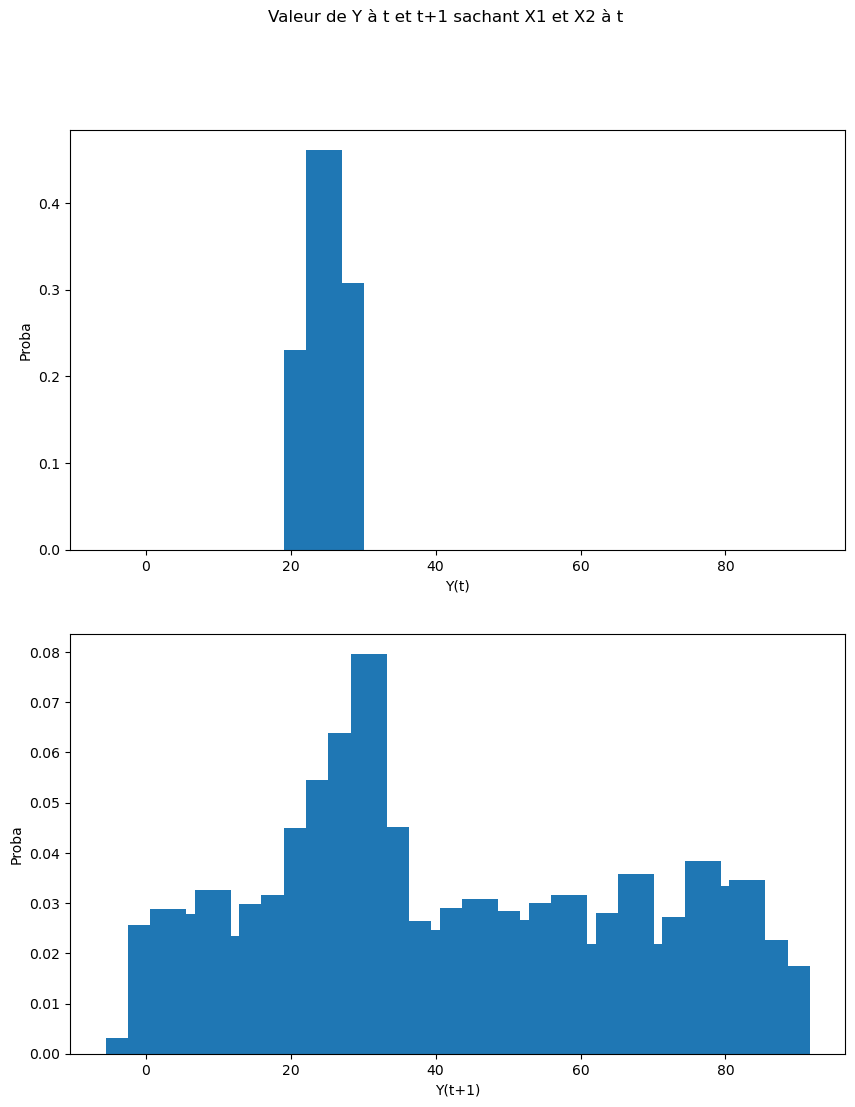

In [64]:
# framework pour l'inférence des DBN 
inference = DBNInference(dbn)

# known observation
evidence = {
    ('X1', 0): discretizer.indexer("X1", -24.32), 
    ('X2', 0): discretizer.indexer("X2", -10.22), 
}  # value must be indice 

evidence = {
    ('X1', 0): 20, 
    ('X2', 0): 19, 
}

# result of question given evidence what about variable
result = inference.forward_inference(variables=[('Y', 0), ("Y", 1)], 
                                     evidence=evidence)
proba_0 = result[("Y", 0)].values
proba_1 = result[("Y", 1)].values

# x-axis
x_ = [discretizer.reverse_indexer(column_name="Y", ind=i) for i in range(len(proba_0))]

print(np.dot(proba_0, x_))
print(np.dot(proba_1, x_))

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

fig.suptitle("Valeur de Y à t et t+1 sachant X1 et X2 à t")

ax[0].bar(x_, proba_0, width=5.)
ax[0].set_xlabel("Y(t)")
ax[0].set_ylabel("Proba")

ax[1].bar(x_, proba_1, width=5.)
ax[1].set_xlabel("Y(t+1)")
ax[1].set_ylabel("Proba")

In [65]:
# framework pour l'inférence des DBN 
inference = DBNInference(dbn)

# known observation
evidence = {
    ('X1', 0): 20, 
    ('X2', 0): 19, 
    ('Y', 0): 7
}

# result of question given evidence what about variable
result = inference.forward_inference(variables=[("Y", 3)], 
                                     evidence=evidence)
proba_1 = result[("Y", 1)].values

# x-axis
x_ = [discretizer.reverse_indexer(column_name="Y", ind=i) for i in range(len(proba_0))]

print(np.dot(proba_1, x_))

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

fig.suptitle("Valeur de Y à t et t+1 sachant X1 et X2 à t")

ax[0].bar(x_, proba_0, width=5.)
ax[0].set_xlabel("Y(t)")
ax[0].set_ylabel("Proba")

ax[1].bar(x_, proba_1, width=5.)
ax[1].set_xlabel("Y(t+1)")
ax[1].set_ylabel("Proba")

TypeError: clone(): argument 'input' (position 1) must be Tensor, not numpy.float64

Maintenant, je souhaite créer un "scénario". 
Ce que j'appelle un scénario c'est étant donné les futures valeurs d'une variables, que prédit le modèle ? 

Concrètement, dans notre expérience, $X_1$ est la variable la plus difficile à saisir. En effet, elel se développe comme un mouvement brownien et est donc par nature presque imprédictible. Il n'est donc pas étonnant d'observer ce que l'on observe au-dessus: plus on prédit loin dans le futur, plus l'incertitude est grande. Le modèle se contente donc de prédire une valeur moyenne constante. 

Dans cette seconde partie, nous espérons qu'en donnant au modèle les futures valeurs de X1 et les valeurs à t de X2 et Y, le modèle soit capable de prédire correctement Y.

In [77]:
# construct scenario
test_set = my_data.tail().reset_index()

scenario = {
    ('X1', 0): discretizer.indexer("X1", test_set.loc[0, "X1"]), 
    ('X2', 0): discretizer.indexer("X2", test_set.loc[0, "X2"]), 
#    ('Y', 0): discretizer.indexer("Y", test_set.loc[0, "Y"]), 
}

scenario_1 = scenario.copy()
scenario_2 = scenario.copy()
scenario_3 = scenario.copy()

for i in range(1, 5):

    # scenario 1 contains full information 
    scenario_1[("X1", i)] = discretizer.indexer("X1", test_set.loc[i, "X1"])
    scenario_1[("X2", i)] = discretizer.indexer("X2", test_set.loc[i, "X2"])

    # scenario 2 only info on X1
    scenario_2[("X1", i)] = discretizer.indexer("X1", test_set.loc[i, "X1"])

    # scenario 3 only info on X2
    scenario_3[("X2", i)] = discretizer.indexer("X2", test_set.loc[i, "X2"])

print(scenario_1)
print(scenario_2)
print(scenario_3)


{('X1', 0): 5, ('X2', 0): 4, ('X1', 1): 3, ('X2', 1): 3, ('X1', 2): 3, ('X2', 2): 3, ('X1', 3): 3, ('X2', 3): 2, ('X1', 4): 4, ('X2', 4): 3}
{('X1', 0): 5, ('X2', 0): 4, ('X1', 1): 3, ('X1', 2): 3, ('X1', 3): 3, ('X1', 4): 4}
{('X1', 0): 5, ('X2', 0): 4, ('X2', 1): 3, ('X2', 2): 3, ('X2', 3): 2, ('X2', 4): 3}


In [78]:
my_data.tail()

,X1,X2,Y
995,-76.733488,-62.902754,64.484638
996,-90.976930,-65.354081,65.791026
997,-92.053122,-70.767925,69.345426
998,-88.524543,-73.329403,73.874825
999,-82.101548,-69.719459,68.823199



Actual value:  65.79102644637142
Y(t+1, scenario 1):  67.04341316883915
Y(t+1, scenario 2):  44.21875588759262
Y(t+1, scenario 3):  67.04341316883915

Actual value:  69.34542613216563
Y(t+2, scenario 1):  67.04341316883915
Y(t+2, scenario 2):  44.3680237516925
Y(t+2, scenario 3):  67.04341316883915

Actual value:  73.87482545083421
Y(t+3, scenario 1):  73.36992135777285
Y(t+3, scenario 2):  44.373645800361714
Y(t+3, scenario 3):  73.36992135777288

Actual value:  68.82319906805665
Y(t+4, scenario 1):  67.04341316883915
Y(t+4, scenario 2):  44.420187680084425
Y(t+4, scenario 3):  67.04341316883914


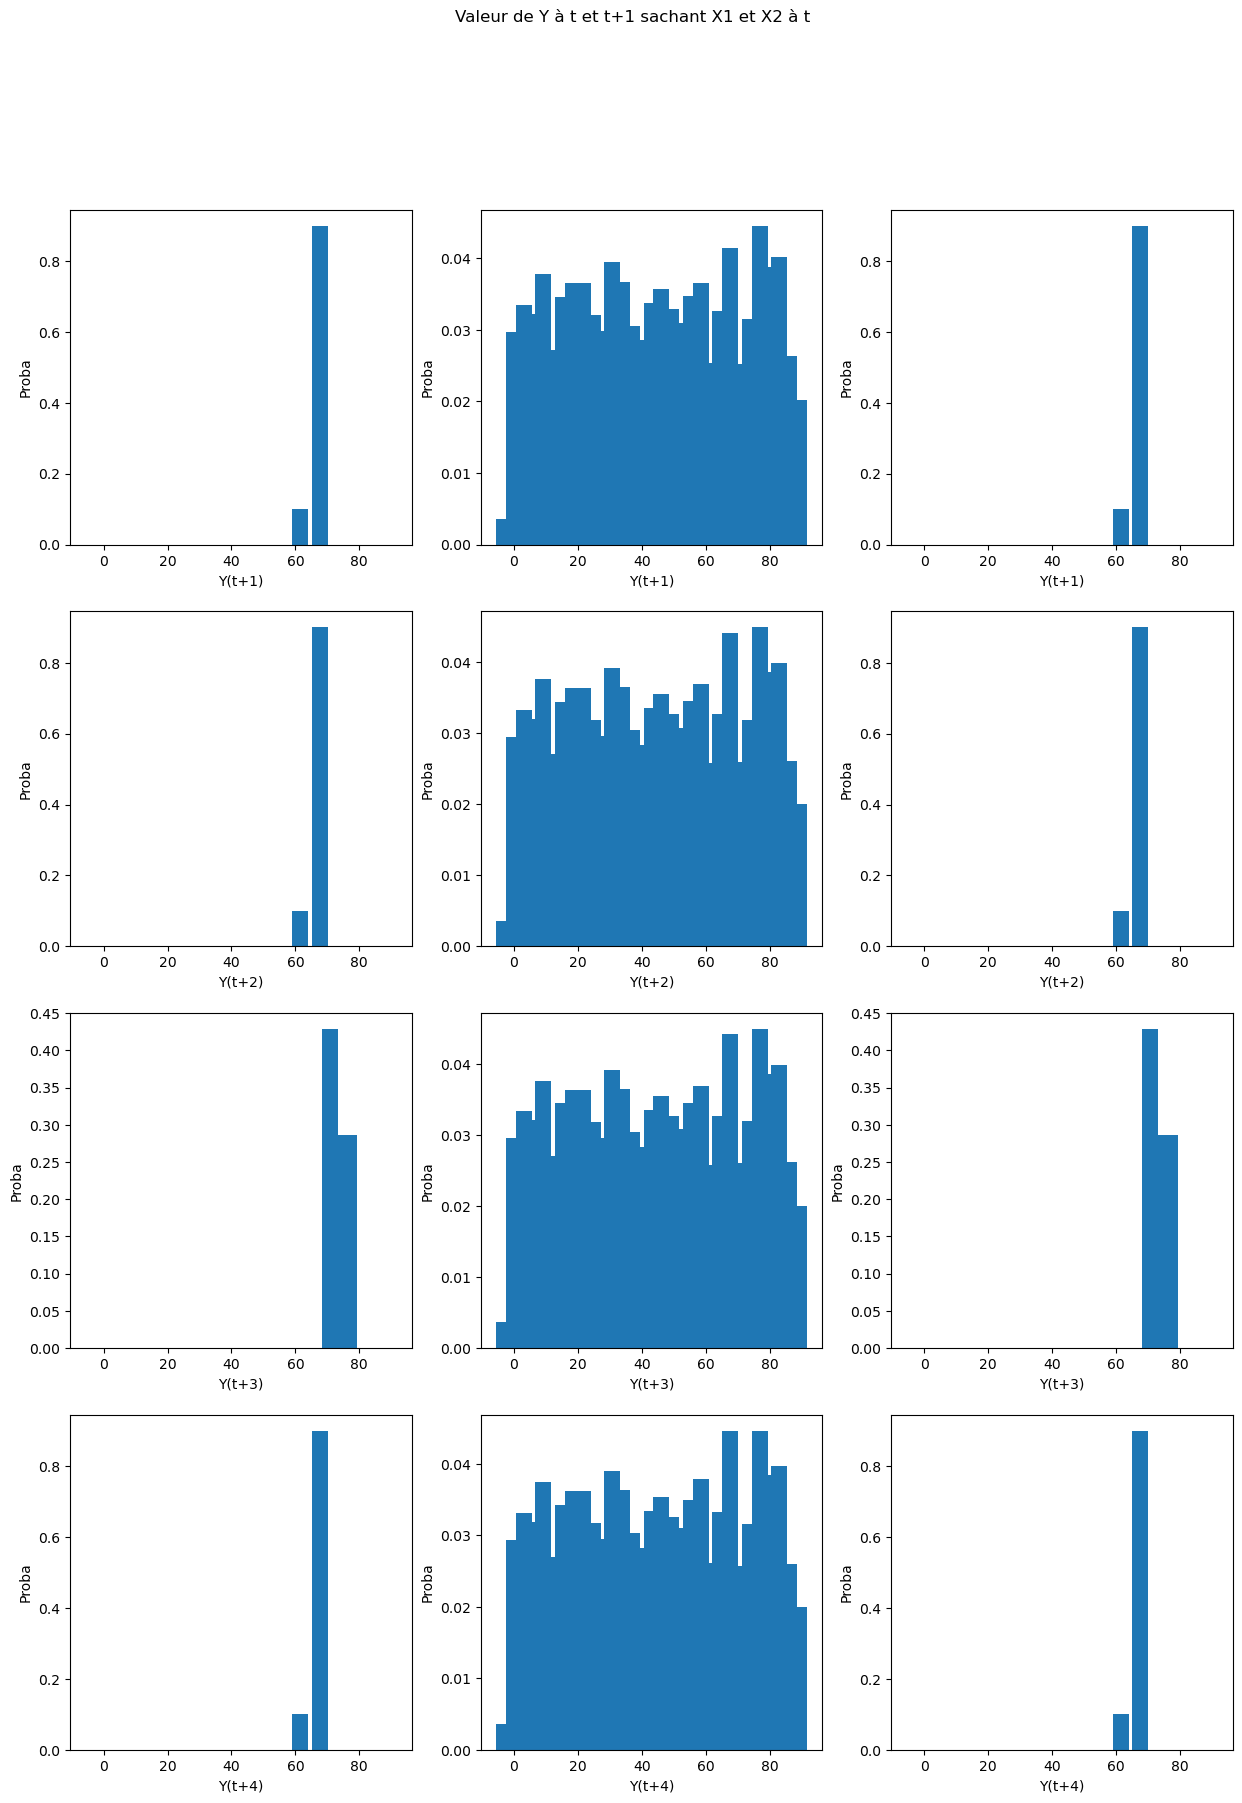

In [81]:
# framework pour l'inférence des DBN 
inference = DBNInference(dbn)

# known observation
variables = [("Y", i) for i in range(1, 5)]

# result of question given evidence what about variable
result_1 = inference.forward_inference(variables=variables, 
                                     evidence=scenario_1)
result_2 = inference.forward_inference(variables=variables, 
                                     evidence=scenario_2)
result_3 = inference.forward_inference(variables=variables, 
                                     evidence=scenario_3)

# x-axis
x_ = [discretizer.reverse_indexer(column_name="Y", ind=i) for i in range(len(proba_0))]

fig, ax = plt.subplots(4, 3, figsize=(15, 20))

fig.suptitle("Valeur de Y à t et t+1 sachant X1 et X2 à t")

for i in range(4):

    print("\nActual value: ", my_data.tail().reset_index().loc[i+1, "Y"])

    proba_1 = result_1[("Y", i+1)].values
    proba_2 = result_2[("Y", i+1)].values
    proba_3 = result_3[("Y", i+1)].values

    print(f"Y(t+{i+1}, scenario 1): ", np.dot(proba_1, x_))
    ax[i, 0].bar(x_, proba_1, width=5.)
    ax[i, 0].set_xlabel(f"Y(t+{i+1})")
    ax[i, 0].set_ylabel("Proba")

    print(f"Y(t+{i+1}, scenario 2): ", np.dot(proba_2, x_))
    ax[i, 1].bar(x_, proba_2, width=5.)
    ax[i, 1].set_xlabel(f"Y(t+{i+1})")
    ax[i, 1].set_ylabel("Proba")

    print(f"Y(t+{i+1}, scenario 3): ", np.dot(proba_3, x_))
    ax[i, 2].bar(x_, proba_3, width=5.)
    ax[i, 2].set_xlabel(f"Y(t+{i+1})")
    ax[i, 2].set_ylabel("Proba")